In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd


Using TensorFlow backend.


In [6]:
data_folder = "../data/Npy/beginning"
fn_prec = "01_prec_training.npy"
fn_temp = "01_temp_training.npy"
fn_mask = "01_mask.npy"
# data_elev = 'Npy/01_dem.npy'
fn_disc = "01_discharge_training.csv"

- import **deephydro module** with networks, losses and metrics

In [7]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath("../src")
# module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

from deephydro.utils import limit_gpu_memory

limit_gpu_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data import

- load output data

In [8]:
from deephydro import data, visualization

df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)
df.head()
visualization.plot_streamflow(df=df, n_labels=20)

FileNotFoundError: [Errno 2] File b'../data/Npy/beginning/01_discharge_training.csv' does not exist: b'../data/Npy/beginning/01_discharge_training.csv'

- load input data

In [5]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [6]:
print(f"x_prec.shape = {x_prec.shape}")
print(f"x_temp.shape = {x_temp.shape}")
print(f"x_mask.shape = {x_mask.shape}")

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


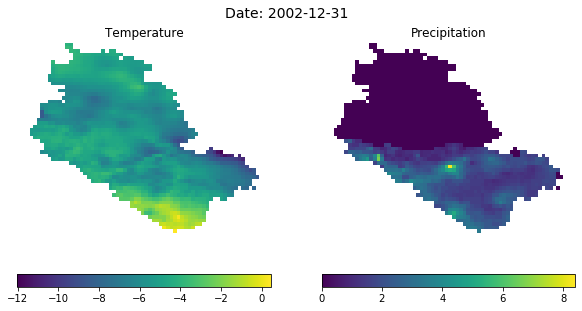

In [7]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, frame=-1)

# Data preparation

- define input data `x` and targets `y`

In [8]:
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df["FDOY"].values

# y: streamflow data
y = df["Q"].values

- split train and validation data

In [9]:
# split train and validation data
validation_fraction = 0.2
validation_first = False

x_train, x_val, y_train, y_val = data.split_train_validation(
    x, y, validation_fraction=validation_fraction, validation_first=validation_first
)

x_doy_train, x_doy_val = data.split_DOY_train_validation(
    x_doy, validation_fraction=validation_fraction, validation_first=validation_first
)

df_train, df_val = data.split_df_train_validation(
    df, validation_fraction=validation_fraction, validation_first=validation_first
)

In [10]:
print("Shape of x_train = ", x_train.shape)
print("Shape of y_train = ", y_train.shape)
print("Shape of x_val   = ", x_val.shape)
print("Shape of y_val   = ", y_val.shape)

Shape of x_train =  (15487, 53, 66, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 53, 66, 2)
Shape of y_val   =  (3871,)


- standardize input (`x_train`) and output data (`y`)

In [11]:
x_train = data.standardize_input_data(x_train)
x_val = data.standardize_input_data(x_val)

In [12]:
y_train, (Y_MEAN, Y_STD) = data.standardize_targets(y_train)
y_val = (y_val - Y_MEAN) / Y_STD

In [13]:
print(f"Y_MEAN = {Y_MEAN:.3f}")
print(f"Y_STD  = {Y_STD:.3f}")
print("Shape of y_train = ", y_train.shape)

Y_MEAN = 715.437
Y_STD  = 426.762
Shape of y_train =  (15487,)


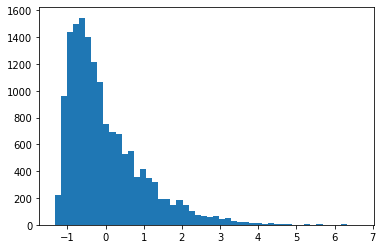

In [14]:
_ = plt.hist(y_train, bins=50)

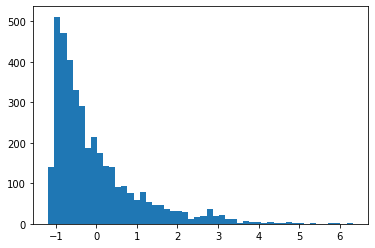

In [15]:
_ = plt.hist(y_val, bins=50)

## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [16]:
# length of image sequence
n_frames = 70
# number of GPUs
n_gpus = 6

if n_gpus > 1:
    # check if this number of GPUs is available
    import keras.backend as K

    assert n_gpus <= len(K.tensorflow_backend._get_available_gpus())

# adjust this to available GPU memory (VRAM)
batch_size = 92 * n_gpus

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = True

W0916 13:20:21.670562 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0916 13:20:21.671165 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [17]:
import keras.backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3',
 '/job:localhost/replica:0/task:0/device:GPU:4',
 '/job:localhost/replica:0/task:0/device:GPU:5']

In [18]:
from deephydro.generator import ImageSequenceGenerator

generator_train = ImageSequenceGenerator(
    data=x_train,
    labels=y_train,
    doy=x_doy_train,
    day_of_year=day_of_year,
    batch_size=batch_size,
    n_frames=n_frames,
    stride=1,
)
generator_val = ImageSequenceGenerator(
    data=x_val,
    labels=y_val,
    doy=x_doy_val,
    day_of_year=day_of_year,
    batch_size=batch_size,
    n_frames=n_frames,
    stride=1,
)

In [19]:
batch = generator_train.__getitem__(0)
if day_of_year:
    print(f"Shape of batch_x im  = {batch[0][0].shape}")
    print(f"Shape of batch_x doy = {batch[0][1].shape}")
    print(f"Shape of batch_y     = {batch[1].shape}")
else:
    print(f"Shape of batch_x = {batch[0].shape}")
    print(f"Shape of batch_y = {batch[1].shape}")

Shape of batch_x = (552, 70, 53, 66, 2)
Shape of batch_y = (552,)


- the `tensorboard()` callback requires validation_data to be given as fixed data instead of a `generator_val`. Therefore, we create a validation dataset `validation_data` here. Unfortunately, this will involve a lot of redundant/copied data. 

In [20]:
# use 1/3 of validation set for validation
n_validation_data = len(x_val) // 3
iterator = range(0, n_validation_data, 1)
validation_data_x = []
validation_data_y = []
for start in iterator:
    end = start + n_frames
    validation_data_x.append(x_val[start:end])
    validation_data_y.append(y_val[end - 1])

validation_data_x = np.array(validation_data_x)
print(validation_data_x.shape)
validation_data_y = np.array(validation_data_y)
print(validation_data_y.shape)
validation_data = (validation_data_x, validation_data_y)

(1290, 70, 53, 66, 2)
(1290,)


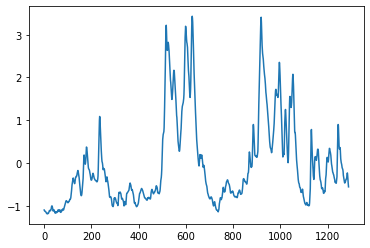

In [21]:
plt.plot(validation_data_y)

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [22]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks

# model = networks.nowcasting_model(input_shape, n_filters=16, dayofyear=day_of_year,
#                                   dropout_rate=0.5,
#                                   batch_norm=True,
#                                   conv2D_preprocessing=True)
model = networks.nowcasting_uncertainty_model(
    input_shape,
    n_filters=16,
    dayofyear=day_of_year,
    dropout_rate=0.5,
    batch_norm=True,
    conv2D_preprocessing=False,
)


model.summary(line_length=120)

W0916 13:20:22.485941 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 13:20:23.511700 35184372383840 deprecation.py:506] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
images (InputLayer)                    (None, 70, 53, 66, 2)      0                                                     
________________________________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)            (None, 70, 26, 32, 16)     10432         images[0][0]                            
________________________________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)            (None, 70, 12, 15, 32)     55424         conv_lst_m2d_1[0][0]                    
________________________________________________________________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)     

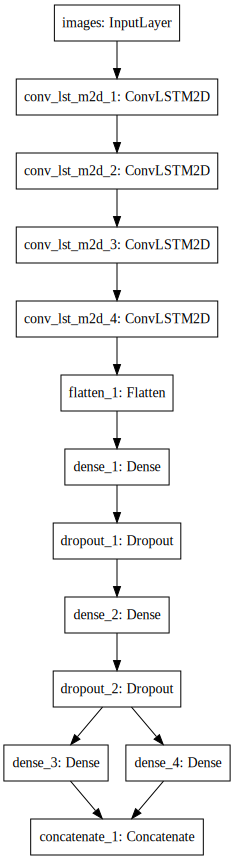

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog="dot", format="svg"))

- compile model: loss, optimizer and metrics

In [24]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc


def build_model(
    model, loss, metrics=ccc, optimizer=optimizers.Adam(lr=1e-4), n_gpus: int = 1
):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model

        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model

# Training

In [25]:
n_epochs = 20

In [26]:
from deephydro.utils import (
    checkpointer,
    early_stopping,
    reduce_learning_rate,
    tensorboard,
)

model_name = (
    "../output/model_wdb_uncertainty_noDOY_NOWcasting_slowlearning_tensorboard.h5"
)
callbacks = [checkpointer(model_name), reduce_learning_rate()]
# early_stopping()]
# tensorboard()]

In [27]:
if n_gpus > 1:
    parallel_model = build_model(model, loss=gauss, n_gpus=n_gpus)
    parallel_model.summary(line_length=120)
    history = parallel_model.fit_generator(
        # training
        generator=generator_train,
        steps_per_epoch=len(x_train) // batch_size,
        epochs=n_epochs,
        # validation # tensorboard histograms does not accept generator
        validation_data=validation_data,
        ## validation
        # validation_data=generator_val,
        # validation_steps=len(x_val)//batch_size,
        # callbacks
        callbacks=callbacks,
        # CPU parallelism
        use_multiprocessing=False,
        # workers=2, # if too large, you'll get CPU memory issues (job gets killed)
        # max_queue_size=10
    )
else:
    model = build_model(model, loss=mse, n_gpus=n_gpus)
    model.summary(line_length=120)
    history = model.fit_generator(
        # training
        generator=generator_train,
        steps_per_epoch=len(x_train) // batch_size,
        epochs=n_epochs,
        # validation
        validation_data=generator_val,
        validation_steps=len(x_val) // batch_size,
        # callbacks
        callbacks=callbacks,
        # CPU parallelism
        # use_multiprocessing=False,
        # workers=12,
        # max_queue_size=10
    )

W0916 13:20:27.825160 35184372383840 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
images (InputLayer)                    (None, 70, 53, 66, 2)      0                                                     
________________________________________________________________________________________________________________________
lambda_1 (Lambda)                      (None, 70, 53, 66, 2)      0             images[0][0]                            
________________________________________________________________________________________________________________________
lambda_2 (Lambda)                      (None, 70, 53, 66, 2)      0             images[0][0]                            
________________________________________________________________________________________________________________________
lambda_3 (Lambda)               

W0916 13:20:29.075405 35184372383840 deprecation.py:323] From /software/ml/JupyterHub/conda-powerai/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
28/28 [==============================] - 78s 3s/step - loss: 0.2804 - ccc: 0.3709 - val_loss: 0.0908 - val_ccc: 0.5503

Epoch 00001: val_loss improved from inf to 0.09076, saving model to ../output/model_wdb_uncertainty_noDOY_NOWcasting_slowlearning_tensorboard.h5
Epoch 2/20
28/28 [==============================] - 51s 2s/step - loss: -0.0200 - ccc: 0.6942 - val_loss: -0.1954 - val_ccc: 0.7837

Epoch 00002: val_loss improved from 0.09076 to -0.19543, saving model to ../output/model_wdb_uncertainty_noDOY_NOWcasting_slowlearning_tensorboard.h5
Epoch 3/20
28/28 [==============================] - 51s 2s/step - loss: -0.2115 - ccc: 0.8145 - val_loss: -0.2648 - val_ccc: 0.8061

Epoch 00003: val_loss improved from -0.19543 to -0.26477, saving model to ../output/model_wdb_uncertainty_noDOY_NOWcasting_slowlearning_tensorboard.h5
Epoch 4/20
28/28 [==============================] - 50s 2s/step - loss: -0.2755 - ccc: 0.8446 - val_loss: -0.3634 - val_ccc: 0.8146

Epoch 00004: val_loss im

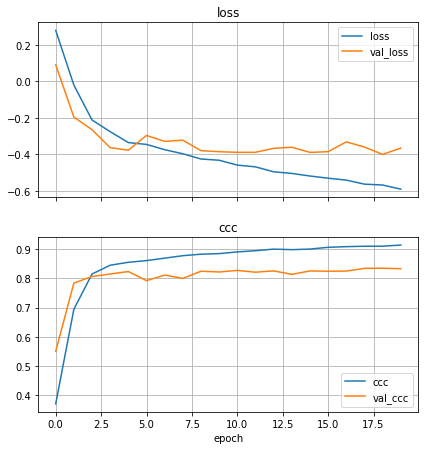

In [28]:
from deephydro import visualization

visualization.plot_history(history)

# Predict

-----

**To do predictions, please use the [predict.ipynb]('./predict.ipynb') notebook.**

-----


In [29]:
# model_name = '../output/model_wdb_uncertainty.h5'

In [30]:
reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    from deephydro.losses import gauss

    model = load_model(model_name, custom_objects={"ccc": ccc, "gauss": gauss})

In [28]:
x_val.shape

(3871, 53, 66, 2)

- predict time series

In [29]:
Y_MEAN

715.4373345386454

In [30]:
Y_STD

426.762298097542

Running inference on 6 GPUs.
0 / 1220
256 / 1220
512 / 1220
768 / 1220
1024 / 1220


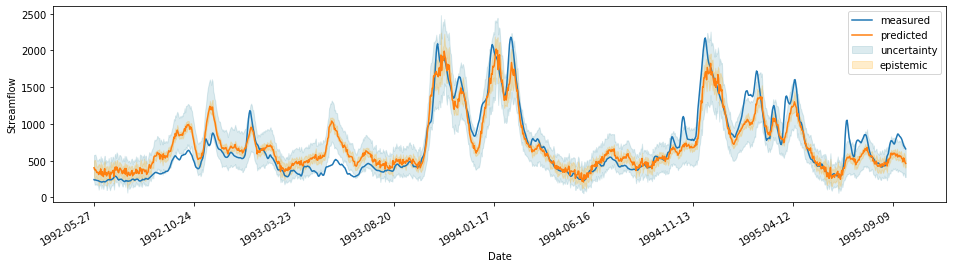

In [90]:
from deephydro.inference import predict_timeseries

maxtime = len(x_val) // 3  # len(x_val) // 20
ts_pred, ts_gt, df_pred = predict_timeseries(
    model=model,
    data=x_val[:maxtime],
    doy=None,  # x_doy_val[:maxtime],
    df=df_val[:maxtime],
    n_frames=n_frames,
    stride=1,
    batch_size=256,
    Y_MEAN=Y_MEAN,
    Y_STD=Y_STD,
    gt=y_val[:maxtime],
    plot=True,
    uncertainty=True,
    T=10,
    n_gpus=n_gpus,
)

Running inference on 6 GPUs.
0 / 3801
256 / 3801
512 / 3801
768 / 3801
1024 / 3801
1280 / 3801
1536 / 3801
1792 / 3801
2048 / 3801
2304 / 3801
2560 / 3801
2816 / 3801
3072 / 3801
3328 / 3801
3584 / 3801


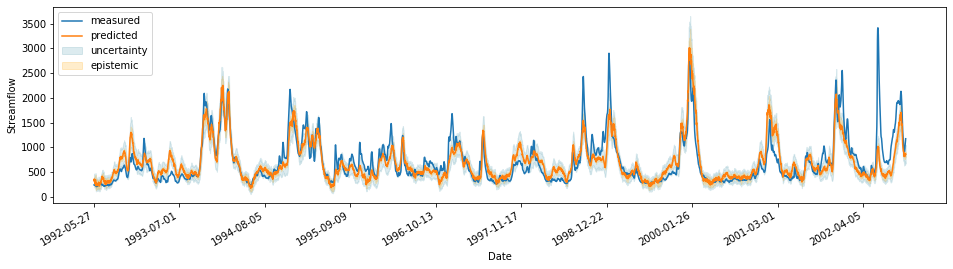

In [31]:
from deephydro.inference import predict_timeseries

maxtime = len(x_val)  # len(x_val) // 20
ts_pred, ts_gt, df_pred = predict_timeseries(
    model=model,
    data=x_val[:maxtime],
    doy=None,  # x_doy_val[:maxtime],
    df=df_val[:maxtime],
    n_frames=n_frames,
    stride=1,
    batch_size=256,
    Y_MEAN=Y_MEAN,
    Y_STD=Y_STD,
    gt=y_val[:maxtime],
    plot=True,
    uncertainty=True,
    T=10,
    n_gpus=6,
)

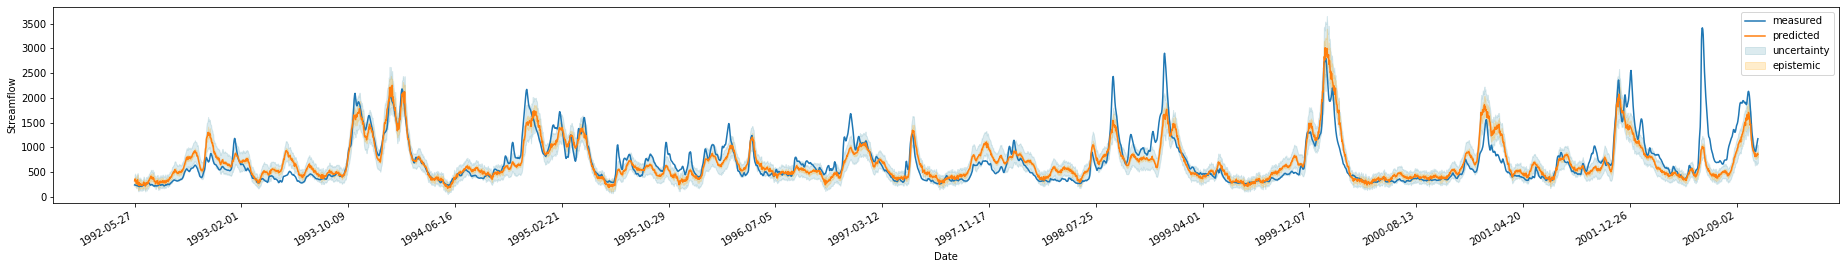

In [32]:
from deephydro.visualization import plot_streamflow

plot_streamflow(
    df_pred,
    n_labels=20,
    filename="../output/streamflow_predicted_full2.pdf",
    figsize=(32, 4),
)
# df_pred

In [34]:
df_pred.head()

Time      Q      Q_pred  Q_pred_sigma  Q_pred_sigma_epi  \
15487  1992-05-27  241.0  323.909149    115.362358         61.198662   
15488  1992-05-28  237.0  361.505707    109.787064         39.433544   
15489  1992-05-29  237.0  321.637604    118.573997         73.340813   
15490  1992-05-30  234.0  324.488586    105.337738         59.533813   
15491  1992-05-31  232.0  268.179718     97.190567         63.342220   

       Q_pred_sigma_alea  
15487          97.791603  
15488         102.460701  
15489          93.171440  
15490          86.900887  
15491          73.714104

(3801,)
(3801,)
(3801,)
(3801,)


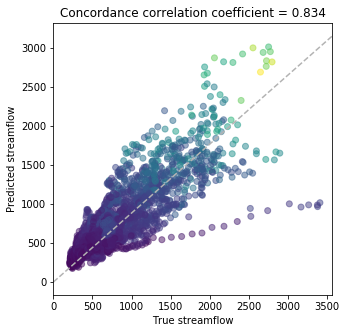

In [39]:
from deephydro.visualization import plot_correlation

plot_correlation(
    df_pred["Q"],
    df_pred["Q_pred"],
    y_pred_sigma=df_pred["Q_pred_sigma"],
    filename="../output/concordance_correlation_full2.pdf",
)

In [ ]:
df_pred.head()

In [36]:
df_pred.to_csv("../output/df_pred.csv")

- predict random samples

In [ ]:
from deephydro.utils import predict_batch

gt, y_pred = predict_batch(
    model, generator=generator_val, n_samples=2000, y_mean=Y_MEAN, y_std=Y_STD
)

In [ ]:
from deephydro.visualization import plot_correlation

plot_correlation(gt, y_pred)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [ ]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][123]

In [ ]:
from deephydro.utils import saliency_map

shap = saliency_map(model, generator=generator_test, image=im)
print(shap.shape)

In [ ]:
from deephydro.visualization import plot_saliency_map

plot_saliency_map(image=im, shap_values=shap, mask=mask)